In [7]:
import matplotlib.pyplot as plt

from utils import *
import jax.numpy as np

from optimize import *
from regression import LogisticRegression

import math
from tqdm import tqdm

# Plotting code

This will show a scatterplot. Each array is a list of optimization runs, containing the training and validation loss.

In [8]:
def scatterplot(saga_losses, sgd_losses):
    plt.scatter(saga_losses[:,0], saga_losses[:,1], label = 'SAGA')
    plt.scatter(sgd_losses[:,0], sgd_losses[:,1], label = 'SGD') 
    
    plt.xlabel('Training loss')
    plt.ylabel('Validation loss')
    plt.title('A comparison of SAGA and SGD in convergence')
    plt.legend()
#

In [9]:
def gather_data(X_train, Y_train, X_val, Y_val, label_0, label_1):
    train_query = np.logical_or(Y_train==label_0, Y_train==label_1)
    val_query = np.logical_or(Y_val==label_0, Y_val==label_1)

    Y_train_query = Y_train[train_query]
    Y_train_mapped = np.where(Y_train_query == label_0, np.zeros(Y_train_query.shape[0]), np.ones(Y_train_query.shape[0]))

    Y_val_query = Y_val[val_query]
    Y_val_mapped = np.where(Y_val_query == label_0, np.zeros(Y_val_query.shape[0]), np.ones(Y_val_query.shape[0]))

    return X_train[train_query][:2500], Y_train_mapped[:2500], X_val[val_query], Y_val_mapped
#

In [10]:
dataset = 'cifar10'
X_train_all = np.load('X_'+dataset+'_train.npy')
Y_train_all = np.load('Y_'+dataset+'_train.npy')
X_val_all = np.load('X_'+dataset+'_val.npy')
Y_val_all = np.load('Y_'+dataset+'_val.npy')

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_to_ind = dict([(cifar10_labels[i], i) for i in range(len(cifar10_labels))])

In [11]:
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['horse'], label_to_ind['dog'])

N = X_train.shape[0]
D = X_train.shape[1]

# number of optimization steps
T = 2**14

# fix the seed
seed = 0

n_runs = 50

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * SGD (diminishing): starting step size is 2/L, ending step size is 1e-2/L
# * SAGA (constant): step size is .1/L

# no need to log anything during optimization -> use in place of the loss function
no_logger = lambda x : 0

In [ ]:
# TODO: add validation accuracy for all notebooks

In [17]:
# collect all SGD datapoints first
sgd_pairs = []

# only calc lipshitz constant once
# change random seed
key = init_prng(0)
lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 0)
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
# TODO: only calc this once
L = lr.lipschitz_constant() 
step_size = diminishing_step_size(2/L, 1e-2/L, T)
update_method = gd()
wF, losses = optimize(w0, data_sampler, no_logger, descent_func, step_size, update_method, T, verbose=False)
sgd_pairs.append([lr.train_loss(wF), lr.validation_loss(wF)])

for i in tqdm(range(1,n_runs-1)):
    
    # change random seed
    key = init_prng(i)
    lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 0)
    w0 = lr.initialization()
    wF, losses = optimize(w0, data_sampler, no_logger, descent_func, step_size, update_method, T, verbose=False)

    sgd_pairs.append([lr.train_loss(wF), lr.validation_loss(wF)])

sgd_pairs = np.array(sgd_pairs)
print(sgd_pairs)

100%|██████████| 48/48 [51:29<00:00, 64.37s/it]

[[0.67600393 0.6823539 ]
 [0.6763589  0.6828391 ]
 [0.67478544 0.6808561 ]
 [0.6763863  0.6828727 ]
 [0.67531455 0.68146855]
 [0.6753855  0.6812219 ]
 [0.67600423 0.68234915]
 [0.6761451  0.6823034 ]
 [0.6764798  0.68272793]
 [0.6756059  0.6817825 ]
 [0.67520875 0.681042  ]
 [0.6759997  0.68194586]
 [0.6761306  0.6825031 ]
 [0.67653966 0.6830091 ]
 [0.6761168  0.6823633 ]
 [0.67536175 0.6816816 ]
 [0.6760668  0.6822971 ]
 [0.67580384 0.68239605]
 [0.67590487 0.682379  ]
 [0.675095   0.6810483 ]
 [0.6759055  0.68235123]
 [0.67557    0.6817206 ]
 [0.67513627 0.6809786 ]
 [0.6746265  0.680948  ]
 [0.6761301  0.68200237]
 [0.6746451  0.68061733]
 [0.67714566 0.6835814 ]
 [0.6751761  0.6814831 ]
 [0.67606205 0.68238956]
 [0.6760505  0.68206966]
 [0.6760649  0.68228716]
 [0.6758051  0.68165493]
 [0.67583394 0.68213856]
 [0.67611426 0.6824621 ]
 [0.67461485 0.6806752 ]
 [0.6756427  0.6821913 ]
 [0.67603785 0.6823786 ]
 [0.6742057  0.67977935]
 [0.6760973  0.68265665]
 [0.67532986 0.6818648 ]


In [18]:
import pickle

sgd_pairs = np.array(sgd_pairs)
print(sgd_pairs)

# Save sgd_pairs to a pickle file
with open('sgd_pairs.pkl', 'wb') as f:
    pickle.dump(sgd_pairs, f)

print("sgd_pairs saved to sgd_pairs.pkl")

[[0.67600393 0.6823539 ]
 [0.6763589  0.6828391 ]
 [0.67478544 0.6808561 ]
 [0.6763863  0.6828727 ]
 [0.67531455 0.68146855]
 [0.6753855  0.6812219 ]
 [0.67600423 0.68234915]
 [0.6761451  0.6823034 ]
 [0.6764798  0.68272793]
 [0.6756059  0.6817825 ]
 [0.67520875 0.681042  ]
 [0.6759997  0.68194586]
 [0.6761306  0.6825031 ]
 [0.67653966 0.6830091 ]
 [0.6761168  0.6823633 ]
 [0.67536175 0.6816816 ]
 [0.6760668  0.6822971 ]
 [0.67580384 0.68239605]
 [0.67590487 0.682379  ]
 [0.675095   0.6810483 ]
 [0.6759055  0.68235123]
 [0.67557    0.6817206 ]
 [0.67513627 0.6809786 ]
 [0.6746265  0.680948  ]
 [0.6761301  0.68200237]
 [0.6746451  0.68061733]
 [0.67714566 0.6835814 ]
 [0.6751761  0.6814831 ]
 [0.67606205 0.68238956]
 [0.6760505  0.68206966]
 [0.6760649  0.68228716]
 [0.6758051  0.68165493]
 [0.67583394 0.68213856]
 [0.67611426 0.6824621 ]
 [0.67461485 0.6806752 ]
 [0.6756427  0.6821913 ]
 [0.67603785 0.6823786 ]
 [0.6742057  0.67977935]
 [0.6760973  0.68265665]
 [0.67532986 0.6818648 ]


In [21]:
saga_pairs = []

# SAGA constant
print("Running SAGA constant")
key = init_prng(0)
lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 0)
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = constant_step_size(0.1/L)

# Initialize SAGA with gradients for all training data
all_gradients = [lr.train_loss_and_grad(w0, [i])[1] for i in range(N)]
saga_update = saga(all_gradients)
update_method = saga_update
wF, losses = optimize(w0, data_sampler, no_logger, descent_func, step_size, update_method, T, verbose=False)
saga_pairs.append([lr.train_loss(wF), lr.validation_loss(wF)])

# Release memory
del lr, w0, all_gradients, saga_update, wF, losses
import gc
gc.collect()

for i in tqdm(range(1,n_runs-1)): # change to n_runs-1 after testing
    
    # change random seed
    key = init_prng(i)
    lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 0)
    w0 = lr.initialization()
    # Initialize SAGA with gradients for all training data
    all_gradients = [lr.train_loss_and_grad(w0, [i])[1] for i in range(N)]
    saga_update = saga(all_gradients)
    update_method = saga_update
    wF, losses = optimize(w0, data_sampler, no_logger, descent_func, step_size, update_method, T, verbose=False)
    saga_pairs.append([lr.train_loss(wF), lr.validation_loss(wF)])
    
    # Release memory after each iteration
    del lr, w0, all_gradients, saga_update, wF, losses
    gc.collect()

saga_pairs = np.array(saga_pairs)
print(saga_pairs)

Running SAGA constant


100%|██████████| 48/48 [1:34:04<00:00, 117.60s/it]

[[0.6682802  0.6739099 ]
 [0.66827583 0.67390835]
 [0.66828305 0.6739132 ]
 [0.66826487 0.6738924 ]
 [0.66827905 0.6739095 ]
 [0.6682695  0.6738988 ]
 [0.66828907 0.673921  ]
 [0.66827905 0.6739108 ]
 [0.6682781  0.6739105 ]
 [0.66828185 0.6739115 ]
 [0.6682786  0.6739098 ]
 [0.6682761  0.67390895]
 [0.66827947 0.67391163]
 [0.6682719  0.673901  ]
 [0.66827124 0.6739032 ]
 [0.6682645  0.67389524]
 [0.66825885 0.67389053]
 [0.66828346 0.6739158 ]
 [0.66827005 0.6738988 ]
 [0.668278   0.6739108 ]
 [0.6682797  0.6739103 ]
 [0.6682734  0.67390543]
 [0.6682853  0.6739187 ]
 [0.668267   0.67389756]
 [0.66826946 0.6738997 ]
 [0.6682689  0.6738998 ]
 [0.6682677  0.6738961 ]
 [0.6682659  0.6738938 ]
 [0.668291   0.6739233 ]
 [0.6682804  0.67390835]
 [0.6682761  0.67390734]
 [0.6682915  0.6739251 ]
 [0.66827047 0.6738988 ]
 [0.6682821  0.67391217]
 [0.6682658  0.67389464]
 [0.6682702  0.6739037 ]
 [0.668279   0.6739082 ]
 [0.668289   0.6739207 ]
 [0.66827536 0.6739045 ]
 [0.66827965 0.67391074]


In [22]:
# Save sgd_pairs to a pickle file
with open('saga_pairs.pkl', 'wb') as f:
    pickle.dump(saga_pairs, f)

print("saga_pairs saved to sgd_pairs.pkl")

saga_pairs saved to sgd_pairs.pkl


### Visualization

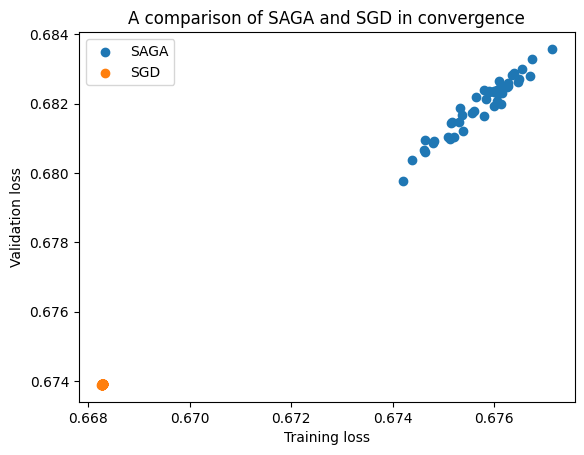

In [23]:
# load arrays from pickle files 
with open('sgd_pairs.pkl', 'rb') as f:
    sgd_pairs = pickle.load(f)

with open('saga_pairs.pkl', 'rb') as f:
    saga_pairs = pickle.load(f)

scatterplot(sgd_pairs, saga_pairs)
